# US Census 94-5 Analysis
A study of  94-95 US census data which can be obtained [here](http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip). The data set is split into 2: a training set ~200,000 rows and a test set ~ 100,000. The purpose of this study is to explore the features contained, extract any meaningful insights and finally apply a predictive model to be implemented on the test set.

## 1 - Data quality
To begin we will import our library dependencies and explore the unzipped training data set:

In [1]:
options(warn=-1)
library(ggplot2)
library(dplyr)
library(randomForest)
library(ROCR)
library(DMwR)
library(corrplot)
library(gridExtra)
library(caTools)
rawTrainingData <- read.csv("data/census_income_learn.csv", header=FALSE)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: lattice
Loading required package: grid

Attaching package: ‘gridExtra’

The following object is masked from ‘package:randomForest’:

    combine

The following object is masked from ‘package:dplyr’:

    combine



Comparing the training data to the metadata text file it  seems that there are some descripancies: we are given 44 named fields are found in the metadata file yet only 42 fields in the data. A visual inspection between the permitted values for each field in the metadata and the values appearing in the data it seems "adjusted gross income", "federal income tax liability", "total person earnings", "total person income" and "fill inc questionnaire for veteran's admin" are our missing fields and filter for unique values

In [2]:
cenusColnames <- c("age","workerClass","industryCode","occuptationCode","adjGrossIncome","education","wagePerHour",
                   "educationLastWeek","maritialStatus","majorIndustryCode","majorOccupationCode","race","hispanicOrigin",
                   "sex","inLabourUnion","unemploymentReason","ftePTEStatus","capitalGains","capitalLoses","stockDividends",
                   "fedIncomeTaxLiability","taxFilerStatus","previousResidenceRegion","previousResidenceState","householdFamilyStatus",
                   "householdSummuary","instanceWeight","migCodeChangeInMSA","migCodeChangeInReg","migCodeChangeWithinReg","inHouseYearAgo",
                   "prevResInSunbelt","noOfPeopleEmployed","familyMembersUnder18","totalPersonEarnings","fatherBirthCountry","motherBirthCountry",
                   "ownBirthCountry","citizenship","totalPersonIncome","isSelfEmployed","taxableIncomeAmount","fillIncQuestVeteranAdmin",
                   "veteransBenefit","weeksWorkedInYear","year","incomeBin")

cenusColnames <- cenusColnames[!(cenusColnames %in% c("adjGrossIncome","fedIncomeTaxLiability","totalPersonEarnings","totalPersonIncome","fillIncQuestVeteranAdmin"))]
trainingData <- unique(rawTrainingData)
colnames(trainingData) <- cenusColnames
head(trainingData)

age,workerClass,industryCode,occuptationCode,education,wagePerHour,educationLastWeek,maritialStatus,majorIndustryCode,majorOccupationCode,⋯,fatherBirthCountry,motherBirthCountry,ownBirthCountry,citizenship,isSelfEmployed,taxableIncomeAmount,veteransBenefit,weeksWorkedInYear,year,incomeBin
73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,⋯,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,⋯,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,⋯,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,⋯,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,⋯,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,⋯,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.


So our dataset consists 42 columns and 196294 unique rows. Let's infer the datatype of each column and compare with our metadata file

In [3]:
source("data/metadata.R")
metadata[order(metadata$datatype,metadata$columnName),]

,columnName,datatype
citizenship,citizenship,factor
education,education,factor
educationLastWeek,educationLastWeek,factor
familyMembersUnder18,familyMembersUnder18,factor
fatherBirthCountry,fatherBirthCountry,factor
ftePTEStatus,ftePTEStatus,factor
hispanicOrigin,hispanicOrigin,factor
householdFamilyStatus,householdFamilyStatus,factor
householdSummuary,householdSummuary,factor
incomeBin,incomeBin,factor


With this let's isolate the character columns and clean them up: they contain both leading and trailing whitespace

In [4]:
catColumns <- as.character(metadata[metadata$datatype=="factor","columnName"])
trainingData[,catColumns] <- sapply(trainingData[,catColumns],function(x) gsub("^\\s+|\\s+$", "", as.character(x)))
trainingData[,catColumns] <-lapply(trainingData[,catColumns],factor)

It is also important that we capture any missing values that appear throughout the dataset. R represents missing/null values by NA and the dataset seems to represent missing/nulls with a '?'. There is also a third value which is of interest: "Not in universe". Technically it is not a missing value, rather it can be interepted as "Not applicable"

In [5]:
naCount <- data.frame(colnames(trainingData),sapply(trainingData,function(x) 100*sum(is.na(x))/length(x)))
colnames(naCount) <- c("columnName","naPercentage")
qmCount <- data.frame(colnames(trainingData),sapply(trainingData,function(x) 100*sum(sapply(x, function(y) y=="?"))/length(x)))
colnames(qmCount) <- c("columnName","qmPercentage")
niuCount <- data.frame(colnames(trainingData),sapply(trainingData,function(x) 100*sum(sapply(x, function(y) tolower(y)=="not in universe"))/length(x)))
colnames(niuCount) <- c("columnName","niuPercentage")
missingCount <- merge(naCount,qmCount,by="columnName")
missingCount <- merge(missingCount,niuCount,by="columnName")
missingCount$missingTotal <- apply(missingCount[,c(2,3,4)],1,sum)
row.names(missingCount) <- NULL
missingCount

columnName,naPercentage,qmPercentage,niuPercentage,missingTotal
age,0,0.000000,0.0000000,0.000000
capitalGains,0,0.000000,0.0000000,0.000000
capitalLoses,0,0.000000,0.0000000,0.000000
citizenship,0,0.000000,0.0000000,0.000000
education,0,0.000000,0.0000000,0.000000
educationLastWeek,0,0.000000,93.6156989,93.615699
familyMembersUnder18,0,0.000000,73.4413686,73.441369
fatherBirthCountry,0,3.414776,0.0000000,3.414776
ftePTEStatus,0,0.000000,0.0000000,0.000000
hispanicOrigin,0,0.000000,0.0000000,0.000000


For the most part our fields are fully populated, however there are 4 columns where almost half of their entries are encoded for. 

## 2 - Exploratory analysis

### 2.1 Target variable
Out target variable is the indicator as to whether an individual earns over 50K in the year i.e. a binary classification problem. A quick plot of the distribution reveals a class imbalance which we may need to consider when fitting our predictive models:


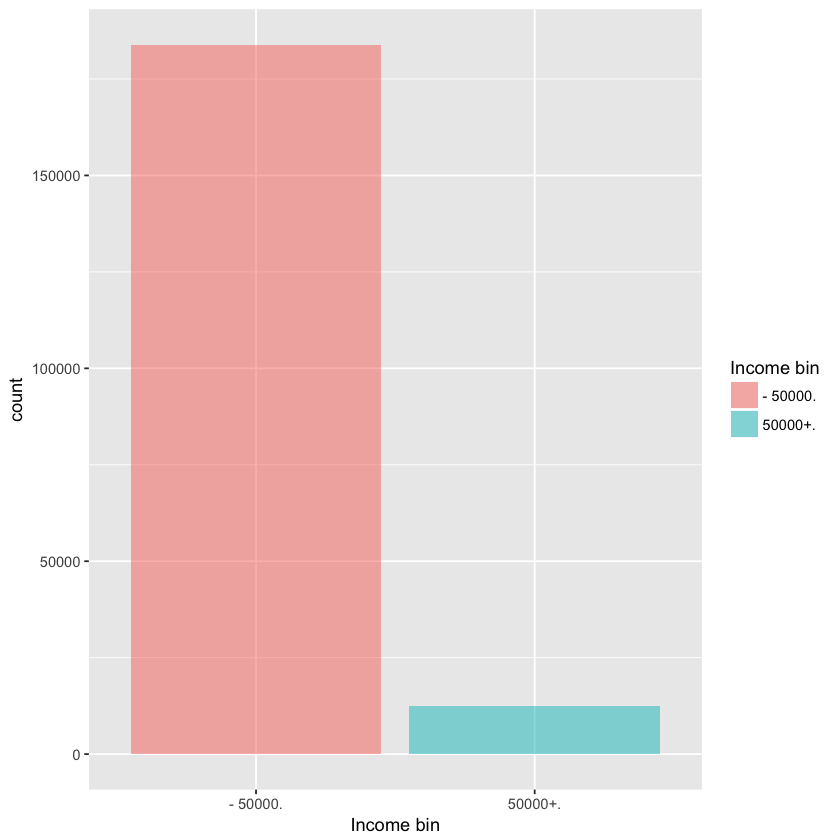

In [6]:
ggplot(trainingData,aes(x=incomeBin)) + 
geom_bar(aes(fill=incomeBin),alpha=0.5) + labs(x="Income bin",fill='Income bin') 

### 2.2 Numeric features
First let us consider the numeric features we have identified and apply a 5-number summary (dropping the "instance weight" feature as advised in the metadata text file)

In [7]:
numericColumns <- as.character(metadata[metadata$datatype %in% c("numeric","integer"),"columnName"])
numericColumns <- numericColumns[!(numericColumns %in% "instanceWeight")]
data.frame(sapply(trainingData[,numericColumns],summary))

,age,wagePerHour,capitalGains,capitalLoses,stockDividends,noOfPeopleEmployed,weeksWorkedInYear
Min.,0.00,0.00,0.0,0.00,0.0,0.000,0.00
1st Qu.,16.00,0.00,0.0,0.00,0.0,0.000,0.00
Median,34.00,0.00,0.0,0.00,0.0,1.000,12.00
Mean,34.93,56.34,441.9,37.93,200.7,1.988,23.55
3rd Qu.,50.00,0.00,0.0,0.00,0.0,4.000,52.00
Max.,90.00,9999.00,100000.0,4608.00,100000.0,6.000,52.00


The monetary variables wagePerHour, 
capitalGains, capitalLoses and stockDividends also seem to be heavily skewed based on the IQR. Let's take a closer look at the non-zero values to see if this is actually the case:

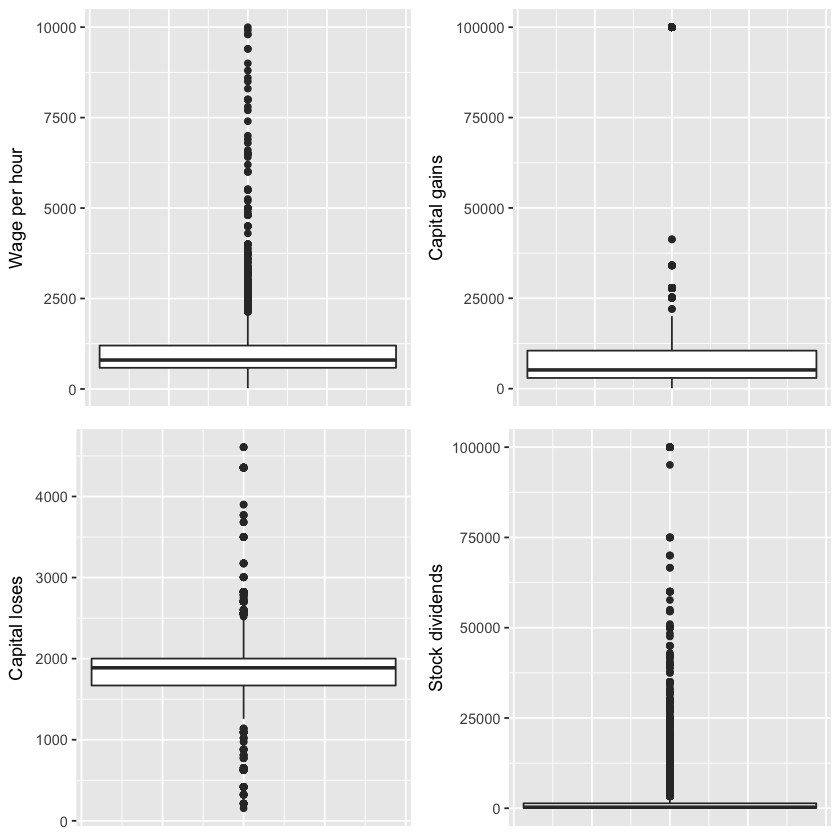

In [8]:
wph <- ggplot(trainingData[trainingData$wagePerHour>0,],aes(x=1,y=wagePerHour)) + 
    geom_boxplot() + ylab("Wage per hour")+theme(axis.title.x=element_blank(),
                           axis.text.x=element_blank(),
                           axis.ticks.x=element_blank())
cg <- ggplot(trainingData[trainingData$capitalGains>0,],aes(x=1,y=capitalGains)) + 
    geom_boxplot() + ylab("Capital gains")+theme(axis.title.x=element_blank(),
                           axis.text.x=element_blank(),
                           axis.ticks.x=element_blank())
cl <- ggplot(trainingData[trainingData$capitalLoses>0,],aes(x=1,y=capitalLoses)) + 
    geom_boxplot() + ylab("Capital loses")+theme(axis.title.x=element_blank(),
                           axis.text.x=element_blank(),
                           axis.ticks.x=element_blank())
sd <- ggplot(trainingData[trainingData$stockDividends>0,],aes(x=1,y=stockDividends)) + 
    geom_boxplot() + ylab("Stock dividends")+theme(axis.title.x=element_blank(),
                           axis.text.x=element_blank(),
                           axis.ticks.x=element_blank())
grid.arrange(wph,cg,cl,sd,nrow=2,ncol=2)

Many outliers for all 4 variables, however in the case of stock dividends and capital gains the maximum values seem to be substantially larger than the rest of their respective distributions. For both cases this value is 99999 and quite a few observations take this. 
We can take a correlation plot:

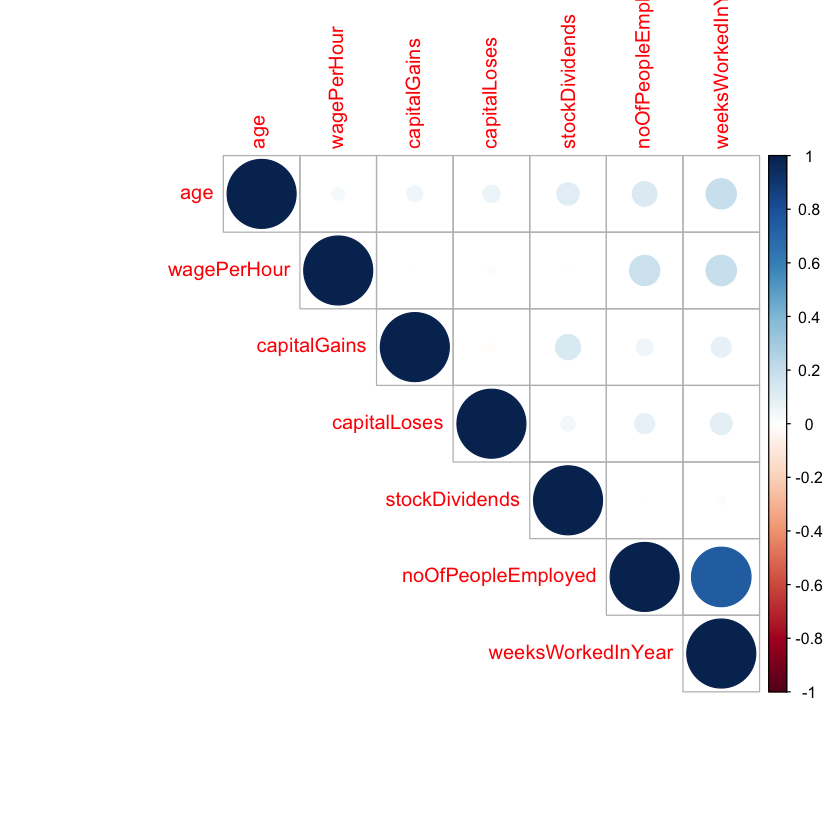

In [9]:
cor1 <- cor(trainingData[,numericColumns[!(numericColumns %in% c("industryCode", "occuptationCode", "isSelfEmployed", "veteransBenefit", "year"))]])
corrplot(cor1,type="upper")

There doesn't seem to be any strong correlation between the numeric features so let us leave them all in for the interim.

Ideally we want to know which features will be our best predictors as to whether someone earns over 50K, so next let's tackle the split for our numeric features.

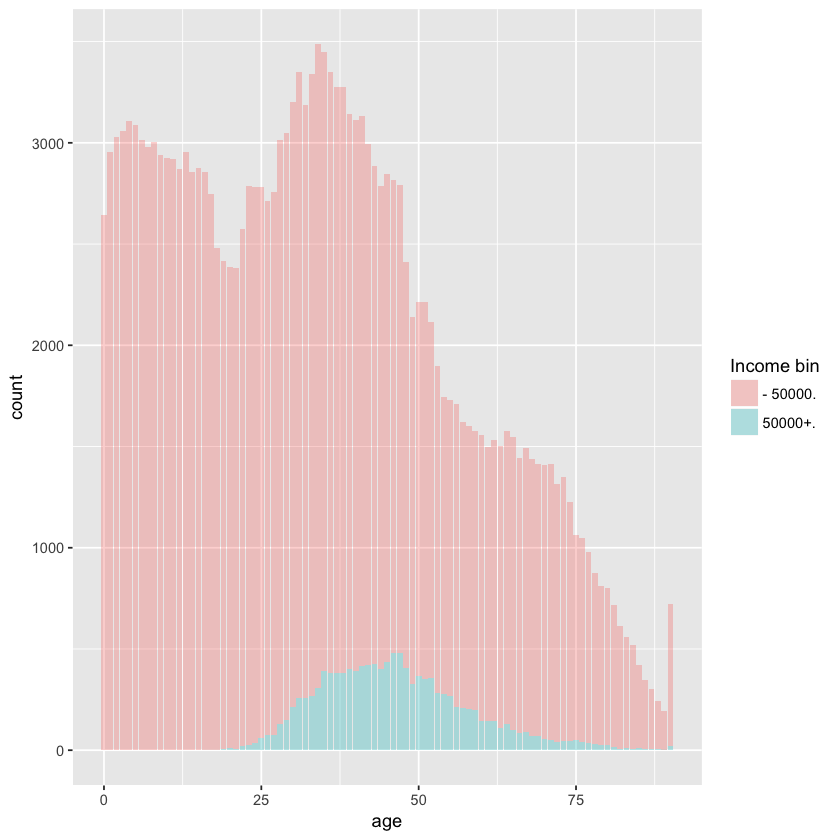

In [10]:
ggplot(trainingData,aes(x=age,fill=incomeBin)) + 
  geom_bar(alpha=0.3) + labs(fill = "Income bin")

The age distribution for those who earn more than 50K is much centered and compact. This makes sense as we would expect younger people to be either still in education or still early in there work careers hence why there income would be much lower.
Next let us consider the "stock dividends" feature: there are actually only approx. 20000 observations that contain a non-zero value so let's just look at those

incomeBin
- 50000.  50000+. 
   15827     5311 

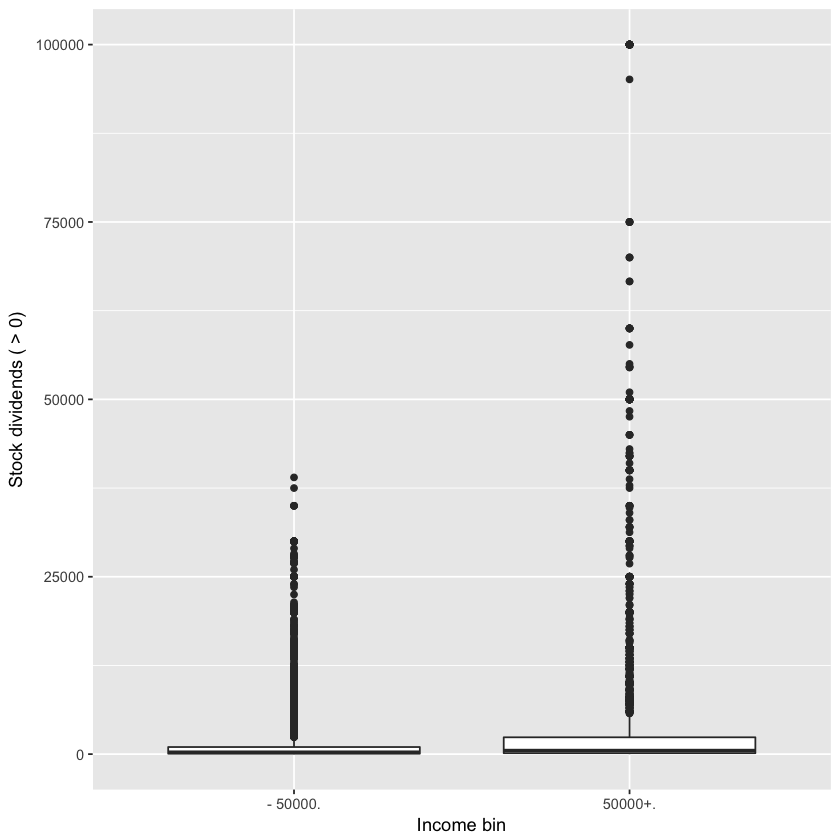

In [11]:
with(trainingData[trainingData$stockDividends>0,],table(incomeBin))
ggplot(trainingData[trainingData$stockDividends>0,],aes(x=incomeBin,y=stockDividends)) + 
    geom_boxplot() + xlab("Income bin") + ylab("Stock dividends ( > 0)")


The 50K+ poplation is a heavy tailed distribution with respect to the stock dividends. Let's take the log of this feature to see if we can control the outliers

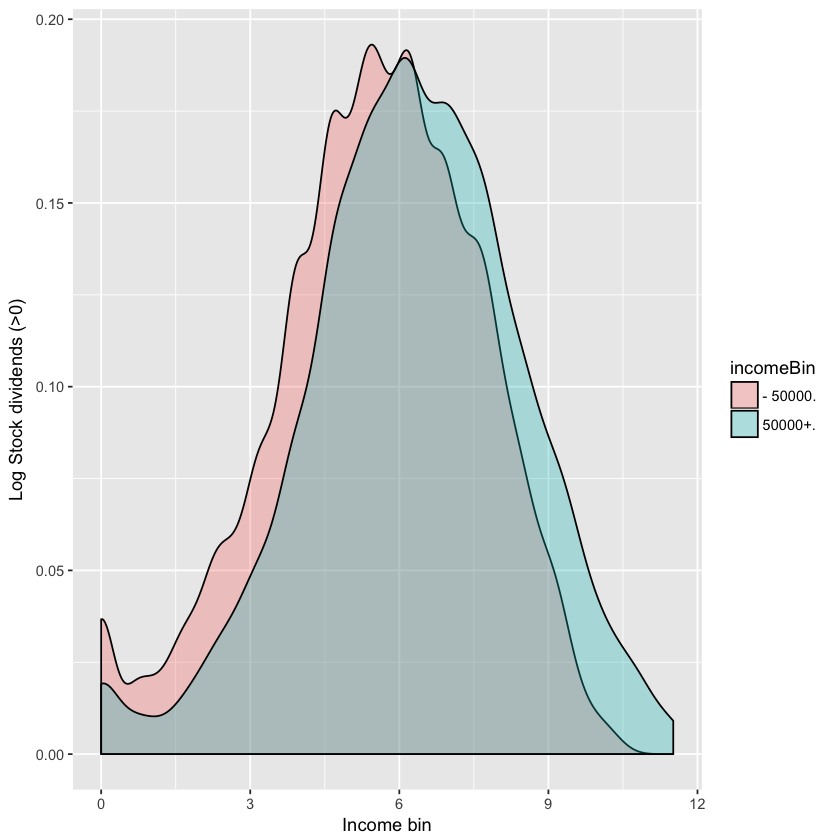

In [12]:
ggplot(trainingData[trainingData$stockDividends>0,],aes(x=log(stockDividends),fill=incomeBin)) + 
  geom_density(alpha=0.3) + xlab("Income bin") + ylab("Log Stock dividends (>0)")

It would make sense that the number of weeks worked per year should lead to a greater income, we have two years of data so let's look

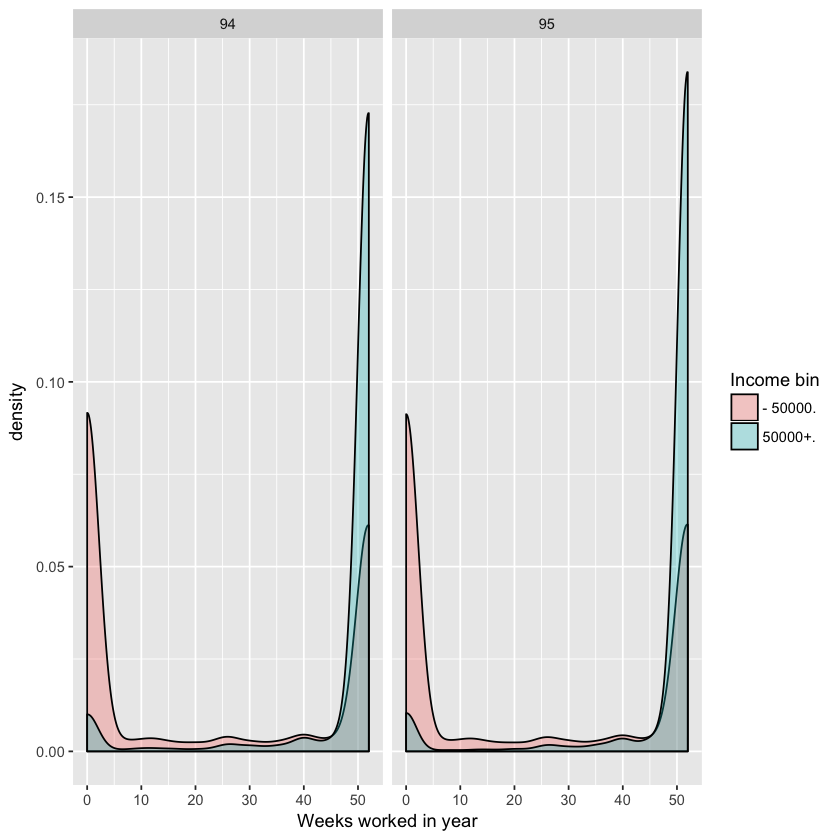

In [13]:
ggplot(trainingData,aes(x=weeksWorkedInYear,fill=incomeBin)) + 
geom_density(alpha=0.3) + facet_grid(.~year) + xlab("weeksWorkedInYear") + labs(x="Weeks worked in year",fill="Income bin")

## 2.2 Categorical features
The full breakdown of the categorical values is as follows:

In [14]:
catColumnDist <- do.call(rbind, lapply(sapply(trainingData[,catColumns],table), data.frame, stringsAsFactors=FALSE))
catColumnDist

,Var1,Freq
workerClass.1,Federal government,2925
workerClass.2,Local government,7783
workerClass.3,Never worked,438
workerClass.4,Not in universe,97029
workerClass.5,Private,72021
workerClass.6,Self-employed-incorporated,3264
workerClass.7,Self-employed-not incorporated,8442
workerClass.8,State government,4227
workerClass.9,Without pay,165
industryCode.1,0,97467


One of the most obvious criteria for higher is education, let's look at the proportion of income across different levels of education:

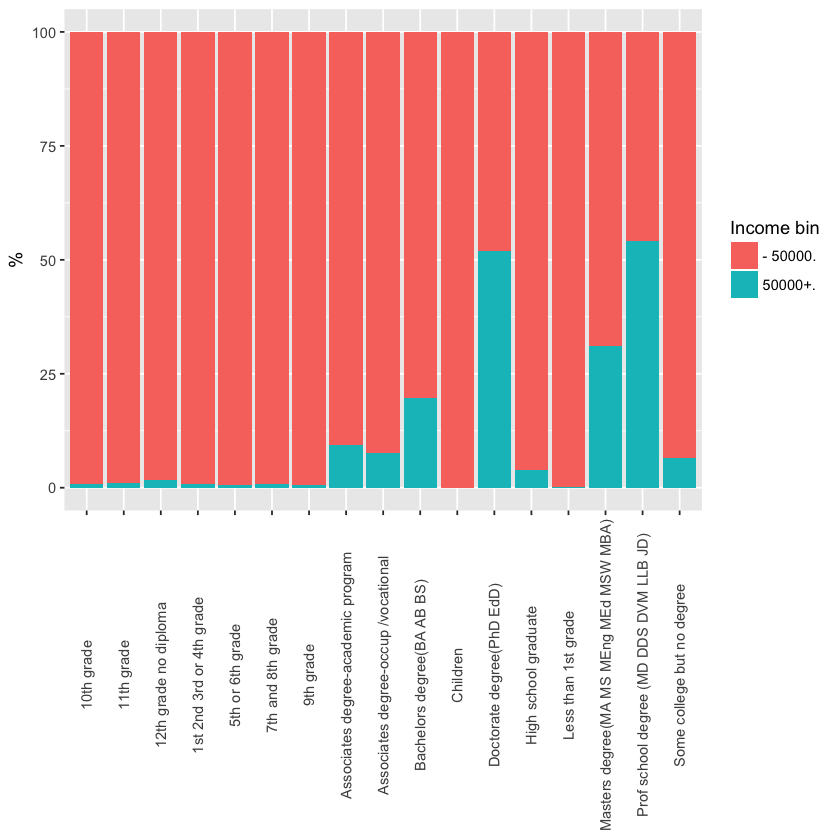

In [15]:
educationTable <- data.frame(100*table(trainingData$education,trainingData$incomeBin)/apply(table(trainingData$education,trainingData$incomeBin),1,sum))
ggplot(educationTable, aes(x=Var1, y=Freq, fill=Var2)) + 
  geom_bar(stat='identity') + 
  theme(axis.text.x=element_text(angle=90,hjust=0.5,vjust=0.5),axis.title.x=element_blank()) + ylab("%") + labs(fill='Income bin')  

As expected third level education plays an important role, especially if it is a more advanced degree. Having completed secondary education as well is also an important distinguiser from not.
Now let's look at job related features: if we consider the industry code first we would expect certain industries to pay more than others:

In [16]:
getProportion <- function(columnA, columnB)
{
  return(data.frame(100*table(columnA,columnB)/apply(table(columnA,columnB),1,sum)))
}#getProportion
majorIndustryProp <- 100*table(trainingData$majorIndustryCode,trainingData$incomeBin)/apply(table(trainingData$majorIndustryCode,trainingData$incomeBin),1,sum)
majorIndustryProp <- data.frame(majorIndustryProp[,1],majorIndustryProp[,2])
colnames(majorIndustryProp) <- c("% is 50000 -","% is + 50000")
majorIndustryProp[order(-majorIndustryProp[,2]),]

,% is 50000 -,% is + 50000
Mining,74.06750,25.9325044
Other professional services,76.70683,23.2931727
Communications,77.13802,22.8619814
Armed Forces,77.77778,22.2222222
Utilities and sanitary services,78.26825,21.7317487
Finance insurance and real estate,81.79007,18.2099268
Public administration,82.06074,17.9392625
Manufacturing-durable goods,83.42578,16.5742179
Wholesale trade,84.64107,15.3589316
Forestry and fisheries,86.02151,13.9784946


Mining tops the list: it is quite a risky job so maybe that is why the yield is the highest. 
The class of worker tells us the sector that the observation belongs to i.e public, private etc:

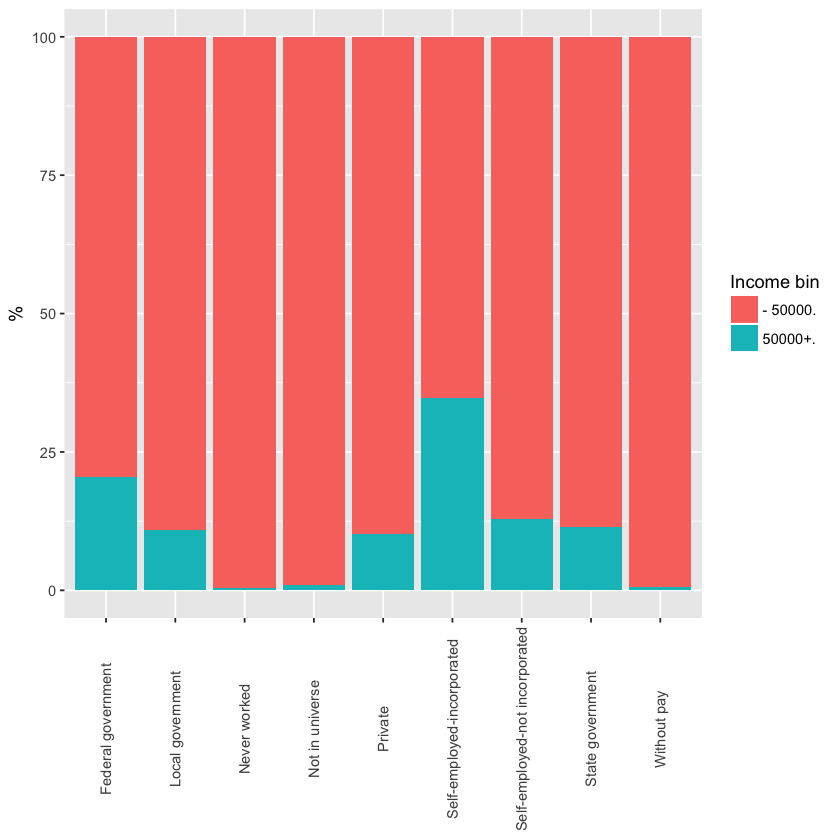

In [17]:
workerTable <- data.frame(100*table(trainingData$workerClass,trainingData$incomeBin)/apply(table(trainingData$workerClass,trainingData$incomeBin),1,sum))
ggplot(workerTable, aes(x=Var1, y=Freq, fill=Var2)) + 
  geom_bar(stat='identity') + 
  theme(axis.text.x=element_text(angle=90,hjust=0.5,vjust=0.5),axis.title.x=element_blank()) + ylab("%") + labs(fill='Income bin')  

From this plot we can clearly distinguish those who are unemployed and what effect is has on income. The divide between self-employed inc. and non-inc. is quite apparent, this is probably due to the complexity of starting a corporation rather than being a sole trader. With the exception of Federal government and Self-employed-inc. it is otherwise fairly homogenous.

## 3 - Feature engineering

Using the observations from section 2 we now can create new features that will be fed into our predictive model: 
- Education: 3rd level grad, some 3rd level, High school grad, high school non-grad
- Class workder: Inc, federal government, unemployed, other
- Drop veterans benefit, year, industry code, occupation code, hispanic origin, member of labour union,
unemployment reason, instance weight, in current house a year ago, family members under 18,
is self employed, household family status and taxable income amount as no obivous benefit is seen


In [18]:
featureEngineering <- function(trainingData)
{
toKeep <- missingCount[missingCount$missingTotal < 50,"columnName"]

trainingData <- trainingData[,colnames(trainingData) %in% toKeep]
trainingData$eduBin <- "highSchoolNonGrad"
trainingData[trainingData$education=="High school graduate","eduBin"] <- "highSchoolGrad"
trainingData[trainingData$education %in% c("Bachelors degree(BA AB BS)","Masters degree(MA MS MEng MEd MSW MBA)",
                                           "Doctorate degree(PhD EdD)","Prof school degree (MD DDS DVM LLB JD)"),"eduBin"] <- "thirdLevel"

trainingData[trainingData$education %in% c("Some college but no degree","Associates degree-academic program","Associates degree-occup /vocational"),"eduBin"]<- "someThirdLevel"
trainingData$eduBin <- as.factor(trainingData$eduBin)

trainingData$workerClassBin <- "other"
trainingData[trainingData$workerClass=="Self-employed-incorporated","workerClassBin"] <- "inc"
trainingData[trainingData$workerClass=="Federal government","workerClassBin"] <- "federal"
trainingData[trainingData$workerClass %in% c("Not in universe","Never worked","Without pay"),"workerClassBin"] <- "unemployed"
trainingData$workerClassBin  <- as.factor(trainingData$workerClassBin)
trainingData$Y <- as.factor(as.integer(trainingData$incomeBin=="50000+."))
trainingData <- trainingData[,!(colnames(trainingData) %in% c("education","workerClass","veteransBenefit","year",
                                                             "industryCode","occupationCode","hispanicOrigin","inLabourUnion",
                                                             "unemploymentReason","instanceWeight","inHouseYearAgo","familyMembersUnder18",
                                                             "isSelfEmployed","householdFamilyStatus","taxableIncomeAmount","incomeBin"))]
return(trainingData)
}#featureEngineering
trainingDataFE <- featureEngineering(trainingData)

## 4 - Model fit
As part of the predictive piece we will apply 2 models:
* Random forest
* Logistic regression

For latency reasons we will use a LOOCV with a 80-20 split on train-test:

In [19]:
set.seed(1)
trainingDataFE$trainTest <- sample.split(trainingDataFE$Y,SplitRatio=0.8)
train <- trainingDataFE[trainingDataFE$trainTest==TRUE,c(-ncol(trainingDataFE))]
test <- trainingDataFE[trainingDataFE$trainTest==FALSE,c(-ncol(trainingDataFE))]

We will fit a random forest model with our select features. In order to evaulate how our model performs there is no point in looking at the model accuracy due to the class balance so let us instead focus on metrics derived from the confusion matrix:

In [20]:
rfModel <- randomForest(Y ~ ., data = train,ntree=500)
rfPredictTrain <- predict(rfModel,train,type="prob")

In [21]:
rfPredictTrain <- predict(rfModel,train,type="prob")
rfPredictTest <- predict(rfModel,test,type="prob")

In [22]:
getROCMetrics <- function(predTable, actFit,thresholdStepsize=0.05)
{
  perfDF <- data.frame(NA, NA,NA,NA,NA,NA)
  if (!is.null(ncol(predTable)))
  {
     predTable <- predTable[,2]
  }#if
  for (thresholdIterator in seq(0,1,thresholdStepsize))
  {
    curPred <- sapply(predTable,function(x) ifelse(x<thresholdIterator,0,1))
    pred <- prediction(curPred,actFit)
    perf <- performance(pred, measure = "tpr", x.measure="fpr")
    auc <-  performance(pred, measure = "auc")
    prec <-  performance(pred, measure = "prec")
    acc <- performance(pred, "acc")
    perfDF <- rbind(perfDF,c(thresholdIterator,acc@y.values[[1]][1],perf@x.values[[1]][2],perf@y.values[[1]][2],auc@y.values[[1]][1],prec@y.values[[1]][2]))
  }#for
  colnames(perfDF) <- c("threshold","acc","fpr","tpr","auc","prec")
  perfDF <- perfDF[!is.na(perfDF$tpr),]
  return(perfDF)
}#getROCMetrics

In [23]:
rfTrainROC <- getROCMetrics(rfPredictTrain,train$Y)
rfTrainROC$setType <- "Train"
rfTestROC <- getROCMetrics(rfPredictTest,test$Y)
rfTestROC$setType <- "Test"

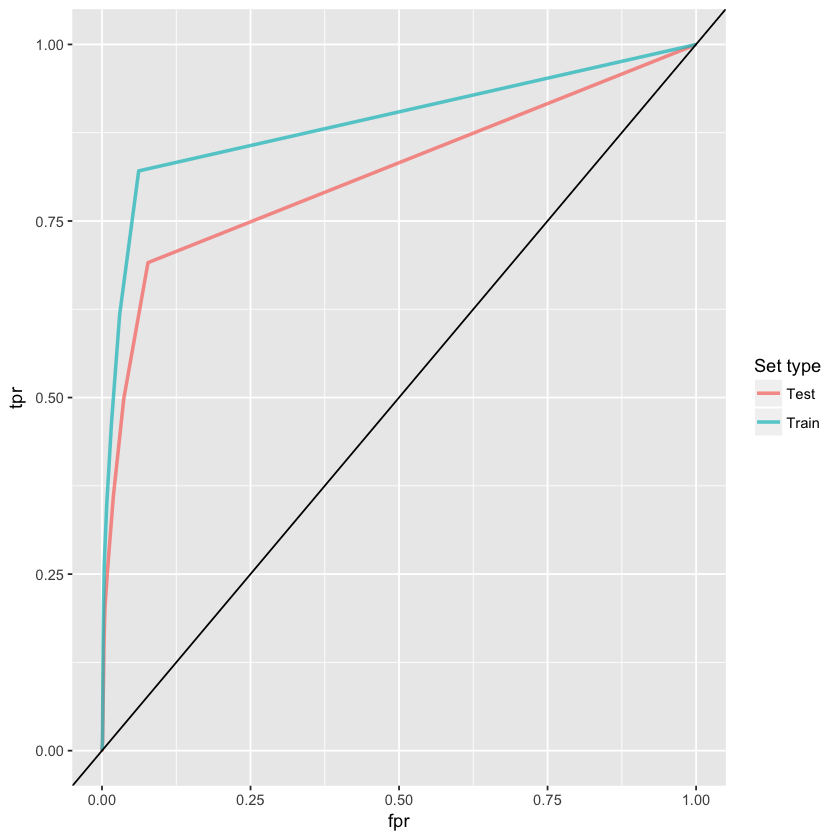

In [24]:
rfROCMetrics <- rbind(rfTrainROC,rfTestROC)
ggplot(rfROCMetrics,aes(x=fpr,y=tpr,colour=setType)) +
    geom_line(size=1,alpha=0.7) +
    geom_abline(aes(intercept=0,slope=1)) + labs(colour="Set type")

Looking at the accuracy on the test set, it is quite high at 93%. However this is quite misleading due to the class imbalance of the response feature. The correct threshold for our class boundary is quite subjective due to whether we would prefer a false negative or a false positive. A value of 0.05 gives the highest AUC of 0.8.
Next we fit a logistic regression model and carry out the same ROC analysis

In [25]:
lrFit <- glm(Y ~ ., data = train, family="binomial")
lrPredictTrain <- predict(lrFit,train,type="response")
lrPredictTest <- predict(lrFit,test,type="response")

In [26]:
lrTrainROC <- getROCMetrics(lrPredictTrain,train$Y)
lrTrainROC$setType <- "Train"
lrTestROC <- getROCMetrics(lrPredictTest,test$Y)
lrTestROC$setType <- "Test"
lrTrainROC
lrTestROC

,threshold,acc,fpr,tpr,auc,prec,setType
2,0.00,0.9369189,1.0000000000,1.00000000,0.5000000,0.06308108,Train
3,0.05,0.9369189,0.1839665602,0.91903897,0.8675362,0.25169335,Train
4,0.10,0.9369189,0.1108543465,0.83484757,0.8619966,0.33645240,Train
5,0.15,0.9369189,0.0746550669,0.75984252,0.8425937,0.40662309,Train
6,0.20,0.9369189,0.0535580779,0.69362003,0.8200310,0.46579893,Train
7,0.25,0.9369189,0.0395704479,0.63345447,0.7969420,0.51872365,Train
8,0.30,0.9369189,0.0293957724,0.57833636,0.7744703,0.56982296,Train
9,0.35,0.9369189,0.0225446884,0.52988088,0.7536681,0.61277142,Train
10,0.40,0.9369189,0.0175083260,0.48122350,0.7318576,0.64918970,Train
11,0.45,0.9369189,0.0134099096,0.43872401,0.7126570,0.68776705,Train


,threshold,acc,fpr,tpr,auc,prec,setType
2,0.00,0.9369301,1.0000000000,1.00000000,0.5000000,0.06306995,Test
3,0.05,0.9369301,0.1857702137,0.91599354,0.8651117,0.24920338,Test
4,0.10,0.9369301,0.1136153553,0.83400646,0.8601956,0.33071749,Test
5,0.15,0.9369301,0.0760426295,0.75565428,0.8398058,0.40081405,Test
6,0.20,0.9369301,0.0541841118,0.68416801,0.8149920,0.45945213,Test
7,0.25,0.9369301,0.0400739492,0.61591276,0.7879194,0.50850283,Test
8,0.30,0.9369301,0.0299059322,0.55936995,0.7647320,0.55734406,Test
9,0.35,0.9369301,0.0238159970,0.50282714,0.7395056,0.58698727,Test
10,0.40,0.9369301,0.0185144908,0.45718901,0.7193373,0.62437948,Test
11,0.45,0.9369301,0.0141917242,0.41478191,0.7002951,0.66300839,Test


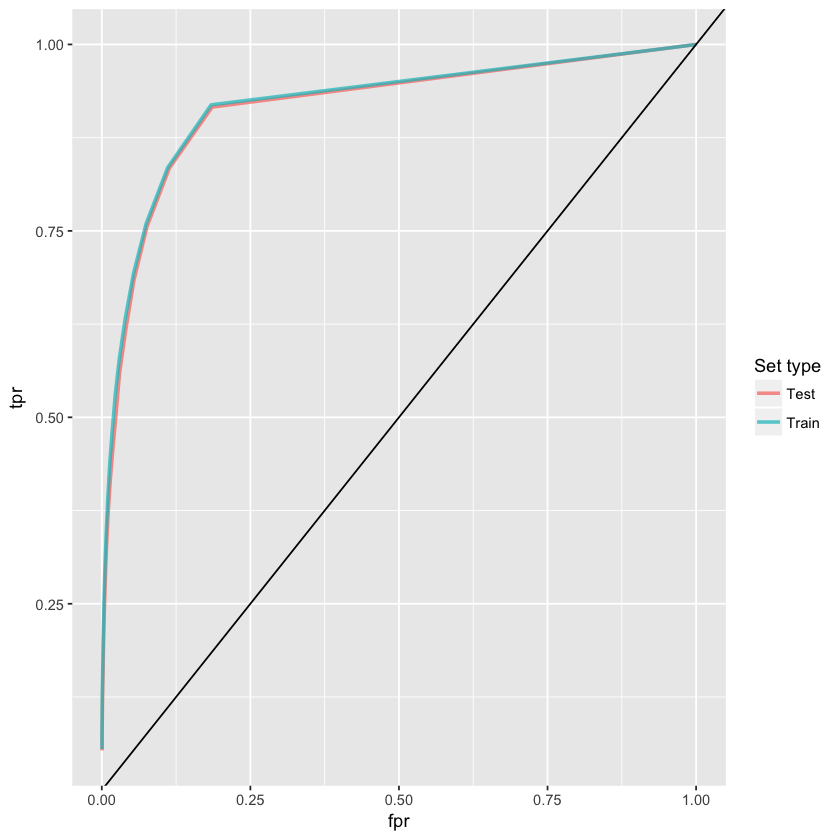

In [27]:
lrROCMetrics <- rbind(lrTrainROC,lrTestROC)
ggplot(lrROCMetrics,aes(x=fpr,y=tpr,colour=setType)) +
    geom_line(size=1,alpha=0.7) +
    geom_abline(aes(intercept=0,slope=1)) + labs(colour="Set type")

Despite having a similar accuracy to the random forest model, the logistic regression model seems to generalise better. Again the optimal threshold is dependent on the problem at hand: let's take this model with a threshold of 0.15 and apply it to our test data set:

In [28]:
rawTestData <- read.csv("data/us_census_full/census_income_test.csv", header=FALSE)
testData <- unique(rawTestData)
colnames(testData) <- cenusColnames
catColumns <- as.character(metadata[metadata$datatype=="factor","columnName"])
testData[,catColumns] <- sapply(testData[,catColumns],function(x) gsub("^\\s+|\\s+$", "", as.character(x)))
testData[,catColumns] <-lapply(testData[,catColumns],factor)
testDataFE <- featureEngineering(testData)

In [29]:
lrFinalPredict <- predict(lrFit,testDataFE,type="response")
lrFinalPredictInt <- ifelse(lrFinalPredict<0.15,0,1)
pred <- prediction(lrFinalPredictInt,testDataFE$Y)
perf <- performance(pred, measure = "tpr", x.measure="fpr")
auc <-  performance(pred, measure = "auc")
prec <-  performance(pred, measure = "prec")
acc <- performance(pred, "acc")

In [30]:
print("----------------")
print("Confusion matrix")
table(testDataFE$Y,lrFinalPredictInt)
print("----------------")
print("----------------")
print(paste("AUC: ", auc@y.values[[1]][1]))
print(paste("FPR: ", perf@x.values[[1]][2]))
print(paste("TPR: ", perf@y.values[[1]][2]))
print(paste("Precision: ", prec@y.values[[1]][2]))
print("----------------")
print("----------------")

[1] "----------------"
[1] "Confusion matrix"


   lrFinalPredictInt
        0     1
  0 85804  6889
  1  1462  4724

[1] "----------------"
[1] "----------------"
[1] "AUC:  0.844669635203938"
[1] "FPR:  0.0743206067340576"
[1] "TPR:  0.763659877141933"
[1] "Precision:  0.40678549900973"
[1] "----------------"
[1] "----------------"


In terms of improvements to predictive performance:
- Feature engineering: this is arguably the most important step for improving a models performance. Derving more bespoke variables, iteractions between variables etc or applying rules from domain knowledge.
- K-fold cross validation: a K-fold approach will guarntee all off our training data will be used. Using the LOOCV approach means we have left out 20% of the data available to us.
- Sampling: due to the class imbalance it is quite difficult to build an accurate predictor for our minority class, in particular for the random forest as it utilizes bootstrapping. Undersampling/oversampling our response feature or applying a class weight may be beneficial here.